### Imports and CUDA

In [101]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Building a "universal" dataset

Based on what was discussed, I will try and build a dataset that captures "universal" data that would help me to predict the next 15 timesteps of the loss ratio, no matter if i start using RENO or CUBIC first.

Build a dataset with both TCP RENO and TCP cubic in it. I will just concatenate them together.
I will use these parameters,


RTT (Round-trip Time)

    Why: Higher RTT often indicates poor network conditions that may lead to higher loss rates, especially if congestion control doesn't adapt well.

RTO (Retransmission Timeout)

    Why: A higher RTO value often correlates with increased packet loss, as it means the sender is waiting longer before retransmitting lost packets.

CWND (Congestion Window)

    Why: This is a critical parameter that reflects how much data the sender can send before needing an acknowledgment. Larger values can result in more congestion and potential loss if the network is not capable of handling it.

SSTHRESH (Slow Start Threshold)

    Why: SSTHRESH determines when a TCP connection switches from slow start to congestion avoidance. It can help determine congestion and packet loss rates when the threshold is crossed.

Bytes Retransmitted (bytes_retrans)

    Why: Directly linked to packet loss. A higher number of retransmitted bytes generally indicates more loss in the network.

Data Segments Out (data_segs_out)

    Why: More data segments sent implies a higher risk of congestion and loss if the network is overwhelmed.

Delivered

    Why: This gives insight into how many segments were successfully delivered without loss, which can be used in the loss ratio calculation.

Segs In (segs_in)

    Why: Helps to track how many segments the receiver acknowledges, giving an indication of network throughput and efficiency.

In [103]:
reno_file_path = "reno1.log.csv"

reno_df = pd.read_csv(reno_file_path, delimiter =";")

cubic_file_path = "cubic1.log.csv"

cubic_df = pd.read_csv(cubic_file_path, delimiter=";")

reno_df = reno_df.iloc[:, :-1]  # Select all rows, and all columns except the last one

cubic_df = cubic_df.iloc[:, :-1]  # Select all rows, and all columns except the last one

print(cubic_df)



     wscale  rto      rtt   mss  pmtu  rcvmss  advmss  cwnd  ssthresh  \
0       6,6  384  182.205  1448  1500     536    1448    33        24   
1       6,6  388  187.547  1448  1500     536    1448    33        24   
2       6,6  396  193.967  1448  1500     536    1448    34        24   
3       6,6  396  193.417  1448  1500     536    1448    34        24   
4       6,6  400  197.738  1448  1500     536    1448    35        24   
...     ...  ...      ...   ...   ...     ...     ...   ...       ...   
3595    6,6  356  154.064  1448  1500     536    1448    26        24   
3596    6,6  356  155.440  1448  1500     536    1448    27        24   
3597    6,6  360  156.876  1448  1500     536    1448    28        24   
3598    6,6  364  162.245  1448  1500     536    1448    29        24   
3599    6,6  364  163.457  1448  1500     536    1448    30        24   

      bytes_sent  bytes_retrans  bytes_acked  segs_out  segs_in  \
0              0              0            0         0  

In [104]:
# --- Cubic Data Manipulation

cubic_df['wscale'] = cubic_df['wscale'].astype(str)

# Replace commas with periods (.) and convert the result to float
cubic_df['wscale'] = cubic_df['wscale'].str.replace(',', '.').astype(float)
cubic_df['loss_ratio'] = (cubic_df['bytes_retrans'] / cubic_df['bytes_sent'])
constant_columns = [col for col in cubic_df.columns if len(cubic_df[col].unique()) == 1]


constant_columns.append("bytes_retrans")
constant_columns.append("bytes_sent")

#dropping the columns that are not listed in the parameters list
constant_columns.append("bytes_acked")
constant_columns.append("segs_out")

print("colunms without any variation: ", constant_columns)
cubic_df = cubic_df.drop(columns=constant_columns)
cubic_df.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

data_min = cubic_df.min(axis=0)
data_max = cubic_df.max(axis=0)
cubic_df_normalized = (cubic_df - data_min) / (data_max - data_min)


# Now df_normalized is your dataset without the constant columns and normalized
cubic_df_normalized["tcp_type"] = 0.0  # 0 for Cubic
print("Check if normalized: ",len(cubic_df_normalized.columns))


#---RENO data manipulation



reno_df['wscale'] = reno_df['wscale'].astype(str)

# Replace commas with periods (.) and convert the result to float
reno_df['wscale'] = reno_df['wscale'].str.replace(',', '.').astype(float)
reno_df['loss_ratio'] = (reno_df['bytes_retrans'] / reno_df['bytes_sent'])
constant_columns = [col for col in reno_df.columns if len(reno_df[col].unique()) == 1]

constant_columns.append("ssthresh")
constant_columns.append("bytes_retrans")
constant_columns.append("bytes_sent")

#dropping the columns that are not listed in the parameters list
constant_columns.append("bytes_acked")
constant_columns.append("segs_out")

print("colunms without any variation: ", constant_columns)
reno_df = reno_df.drop(columns=constant_columns)
reno_df.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

data_min = reno_df.min(axis=0)
data_max = reno_df.max(axis=0)
reno_df_normalized = (reno_df - data_min) / (data_max - data_min)


# Now df_normalized is your dataset without the constant columns and normalized
reno_df_normalized["tcp_type"] = 1.0  # 1 for Reno

print("Check if normalized: ",len(reno_df_normalized.columns))

print(reno_df_normalized.columns)

print(loss_ratio)



colunms without any variation:  ['wscale', 'mss', 'pmtu', 'rcvmss', 'advmss', 'ssthresh', 'rcv_space', 'rcv_ssthresh', 'bytes_retrans', 'bytes_sent', 'bytes_acked', 'segs_out']
Check if normalized:  9
colunms without any variation:  ['wscale', 'mss', 'pmtu', 'rcvmss', 'advmss', 'rcv_space', 'rcv_ssthresh', 'ssthresh', 'bytes_retrans', 'bytes_sent', 'bytes_acked', 'segs_out']
Check if normalized:  9
Index(['rto', 'rtt', 'cwnd', 'segs_in', 'data_segs_out', 'lastrcv',
       'delivered', 'loss_ratio', 'tcp_type'],
      dtype='object')


### For now, 24/5/2025 2250, I will just try and predict with just all the information. See how well it does?

### Creating of Sequences

In [105]:
# print(df_normalized["wscale"])
seq_length = 1
forecast_steps = 15  # Predict the next 15 seconds


def create_sequences(input, labels, seq_length, forecast_steps):
    xs, ys = [], []
    for i in range(len(input) - seq_length - forecast_steps + 1):
        xs.append(input[i : i + seq_length])  # Input sequence
        ys.append(labels[i + seq_length : i + seq_length + forecast_steps])  # Next `forecast_steps` values
    return np.array(xs), np.array(ys)

cubic_X, cubic_y = create_sequences(cubic_df_normalized.values, cubic_df_normalized['loss_ratio'].values, seq_length, forecast_steps)
reno_X, reno_y = create_sequences(reno_df_normalized.values, reno_df_normalized['loss_ratio'].values, seq_length, forecast_steps)

data_reno_tensor = torch.tensor(reno_df_normalized.values, dtype=torch.float32)
new_reno_X = torch.tensor(reno_X,dtype=torch.float32)
new_reno_y = torch.tensor(reno_y[:,:, None], dtype=torch.float32)
print("reno data tensor:", new_reno_X.shape)
print("reno loss tensor:", new_reno_y.shape)


data_cubic_tensor = torch.tensor(reno_df_normalized.values, dtype=torch.float32)
new_cubic_X = torch.tensor(cubic_X,dtype=torch.float32)
new_cubic_y = torch.tensor(cubic_y[:,:, None], dtype=torch.float32)
print("cubic data tensor:", new_cubic_X.shape)
print("cubic loss tensor:", new_cubic_y.shape)

reno data tensor: torch.Size([3585, 1, 9])
reno loss tensor: torch.Size([3585, 15, 1])
cubic data tensor: torch.Size([3585, 1, 9])
cubic loss tensor: torch.Size([3585, 15, 1])


In [ ]:
train_reno_size = int(len(data_reno_tensor) *0.8)
train_cubic_size = int(len(data_cubic_tensor)*0.8)
#I remove the first batch because it is just full of zeros,

# X_train, X_test = new_X[64:train_size], new_X[train_size:]
# y_train, y_test = new_y[64:train_size], new_y[train_size:]

X_reno_train, X_reno_test = new_reno_X[64:train_reno_size], new_reno_X[train_reno_size:]
y_reno_train, y_reno_test = new_reno_y[64:train_reno_size], new_reno_y[train_reno_size:]

X_cubic_train, X_cubic_test = new_cubic_X[64:train_cubic_size], new_cubic_X[train_cubic_size:][:-3]
y_cubic_train, y_cubic_test = new_cubic_y[64:train_cubic_size], new_cubic_y[train_cubic_size:][:-3]

X_train = torch.cat([X_reno_train, X_cubic_train], dim=0)
y_train = torch.cat([y_reno_train, y_cubic_train], dim=0)

X_test = torch.cat([X_reno_test, X_cubic_test], dim=0)
y_test = torch.cat([y_reno_test, y_cubic_test], dim=0)

# Print the shapes to verify the split

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32  # Reduce from 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("length: ", len(train_loader))

# Example of accessing a batch of data
for inputs, targets in test_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    
    break  # Only print the first batch for verification


length:  176
Inputs: torch.Size([32, 1, 9]), Targets: torch.Size([32, 15, 1])


In [107]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, batch_first = True)
        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, cell_state=None, hidden_state=None):
        # Forward pass through the LSTM cell
        if hidden_state is None or cell_state is None:
            hidden_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
            cell_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        hidden = (cell_state, hidden_state)
        output, new_memory = self.lstm(inputs, hidden)
        cell_state, hidden_state = new_memory
        output = self.linear(output)  # Linear layer on all time steps
        return output, cell_state, hidden_state, # Return correct order

In [108]:
def train(model, dataloader, num_epochs, learning_rate):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_values = []
    for epoch in range(num_epochs):
        total_loss = 0  # Track total loss for averaging
        hidden_state, cell_state = None, None  # Reset hidden states for each epoch

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            if batch_idx == len(dataloader) - 1:  
                break  # Skip the last batch

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)


            # Compute loss
            loss = criterion(output, targets)
            total_loss += loss.item()  # Sum up the loss for averaging

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Detach hidden states to prevent memory buildup
            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

            # Print some sample outputs periodically

            print("total_loss: ", total_loss)

        # Print average loss for the epoch

        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
    
    plt.plot(range(num_epochs), loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


total_loss:  0.3752003312110901
total_loss:  0.738427460193634
total_loss:  1.0914599001407623
total_loss:  1.4048630893230438
total_loss:  1.6763657331466675
total_loss:  1.9255870282649994
total_loss:  2.1871921122074127
total_loss:  2.4614335894584656
total_loss:  2.750666707754135
total_loss:  3.024747759103775
total_loss:  3.2899048030376434
total_loss:  3.5363264083862305
total_loss:  3.7801357209682465
total_loss:  4.031608551740646
total_loss:  4.307840406894684
total_loss:  4.590445399284363
total_loss:  4.854794949293137
total_loss:  5.117209106683731
total_loss:  5.365234315395355


c:\Users\nicho\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 15, 1])) that is different to the input size (torch.Size([32, 1, 15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_loss:  5.601874068379402
total_loss:  5.820207983255386
total_loss:  6.033719047904015
total_loss:  6.242800608277321
total_loss:  6.443945333361626
total_loss:  6.639442637562752
total_loss:  6.835882931947708
total_loss:  7.037309363484383
total_loss:  7.236499652266502
total_loss:  7.429990217089653
total_loss:  7.609129577875137
total_loss:  7.786364853382111
total_loss:  7.952569633722305
total_loss:  8.109119281172752
total_loss:  8.25873178243637
total_loss:  8.401838839054108
total_loss:  8.536995574831963
total_loss:  8.663872241973877
total_loss:  8.77904898673296
total_loss:  8.88331363350153
total_loss:  8.977562993764877
total_loss:  9.065509229898453
total_loss:  9.144088745117188
total_loss:  9.216834962368011
total_loss:  9.278835117816925
total_loss:  9.331984348595142
total_loss:  9.378411695361137
total_loss:  9.417196989059448
total_loss:  9.449824120849371
total_loss:  9.477819981053472
total_loss:  9.502380184829235
total_loss:  9.524429935961962
total_loss:

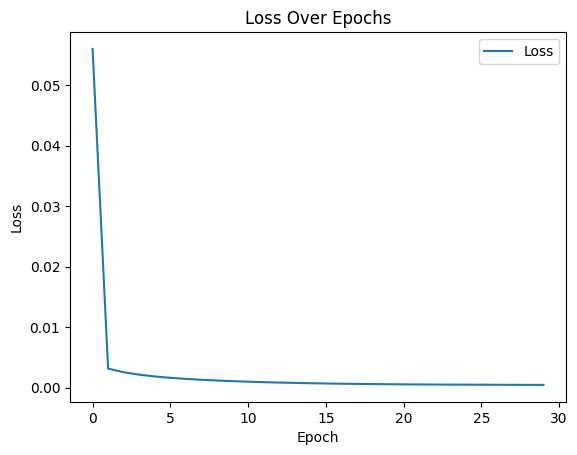

In [109]:
# Define the model parameters
# Following the research paper's instructions
input_size = 9
hidden_size = 20
num_layers = 1 # Can be changed to stack multiple LSTM layers!
output_size = 15
dataloader = train_loader

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
train(model, dataloader, num_epochs = 30, learning_rate = 0.001)


Predicted output:  tensor([[0.5747, 0.6022, 0.6484, 0.6224, 0.5740, 0.6102, 0.6338, 0.5942, 0.6399,
         0.6110, 0.5898, 0.6051, 0.6270, 0.5892, 0.6211]])
Target:  tensor([[0.6108],
        [0.6106],
        [0.6104],
        [0.6102],
        [0.6099],
        [0.6097],
        [0.6095],
        [0.6093],
        [0.6091],
        [0.6089],
        [0.6087],
        [0.6085],
        [0.6083],
        [0.6107],
        [0.6106]])
Predicted output:  tensor([[0.5309, 0.5311, 0.5272, 0.5337, 0.5309, 0.5321, 0.5325, 0.5292, 0.5302,
         0.5317, 0.5308, 0.5293, 0.5304, 0.5313, 0.5267]])
Target:  tensor([[0.5230],
        [0.5254],
        [0.5253],
        [0.5252],
        [0.5250],
        [0.5248],
        [0.5246],
        [0.5245],
        [0.5243],
        [0.5242],
        [0.5240],
        [0.5238],
        [0.5237],
        [0.5235],
        [0.5234]])
Average Validation Loss: 0.0004608497


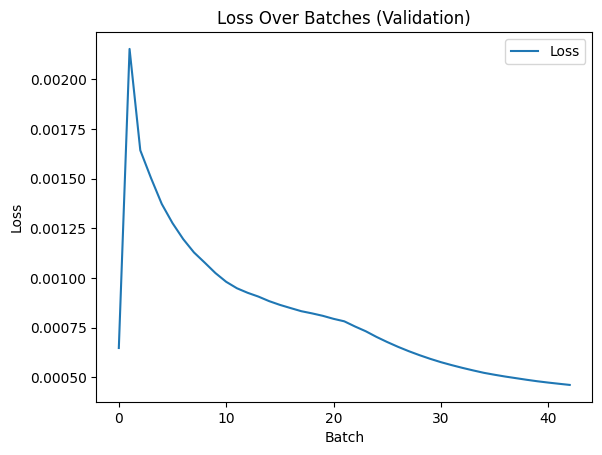

In [111]:

model.eval()

# Initialize variables to track loss
total_val_loss = 0
num_batches = 0
total_lost_values = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx == len(test_loader) - 1:  
            break  # Skip the last batch

        # Initialize hidden state and cell state for each batch
        if hidden_state is not None:
            hidden_state = hidden_state.detach()
        if cell_state is not None:
            cell_state = cell_state.detach()

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)
        if batch_idx % 30 == 0:
            print("Predicted output: ", output[0])
            print("Target: ", targets[0])


        # Compute loss for this batch
        loss = criterion(output, targets)
        
        # Accumulate loss
        total_val_loss += loss.item()  # Add the batch loss to total
        total_lost_values.append(total_val_loss / (batch_idx + 1))  # Average loss so far
    
        num_batches += 1

# Compute average loss for the entire validation set
avg_loss = total_val_loss / num_batches

# Print validation results
print(f'Average Validation Loss: {avg_loss:.10f}')

# Plot the loss curve
plt.plot(range(num_batches), total_lost_values, label='Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Over Batches (Validation)')
plt.legend()
plt.show()
